In [1]:
from __future__ import division

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Phisher
from scipy.integrate import simps, trapz, quad, dblquad, nquad
from scipy import constants
from scipy.special import erfc
import camb
from camb import model, initialpower
import helper_functions as hp
from Bias_Scale_Class_perK import Cosmos

%matplotlib inline
plot_ = True

---

In [3]:
kmin=0.00012
kmax=0.2
N=55
Ks=np.linspace(kmin, kmax, N)
dK=Ks[1]-Ks[0]
p = {'H0': 67, 'Omegab0': 0.02256/0.67**2, 'Omegam0': (0.1142+0.02256)/0.67**2, 'fnl': 5}

In [12]:
def fisher(ckwargs={},c1kwargs={},c2kwargs={},c3kwargs={}):
    
    print(list(ckwargs.keys())[0],list(c2kwargs.keys())[0])
    
    bScale_=False
    if (list(ckwargs.keys())[0]=='fnl' or list(c2kwargs.keys())[0]=='fnl'): 
        print('\t bScale on')
        bScale_=True
        
    FXX = 0.0

    for z in np.linspace(0.1,0.5,5):

        c = Cosmos(z, kmin, kmax, N, **ckwargs)
        c.setPower()
        c.setMlim()

        c1 = Cosmos(z, kmin, kmax, N, **c1kwargs)
        c1.setPower()
        c1.setMlim()

        c2 = Cosmos(z, kmin, kmax, N, **c2kwargs)
        c2.setPower()
        c2.setMlim()

        c3 = Cosmos(z, kmin, kmax, N, **c3kwargs)
        c3.setPower()
        c3.setMlim()

        for m in range(2):
            for n in range(2):
                dlnPhdp1 = (np.log(c1.Ph_mn(m,n,bScale=bScale_))-np.log(c.Ph_mn(m,n,bScale=bScale_)))/((list(ckwargs.values())[0]*0.1))
                dlnPhdp2 = (np.log(c3.Ph_mn(m,n,bScale=bScale_))-np.log(c2.Ph_mn(m,n,bScale=bScale_)))/((list(c2kwargs.values())[0]*0.1))            
                FXX += np.sum(dlnPhdp1 * dlnPhdp2 * c.Veff_mn(m,n,bScale=bScale_) * Ks**2 * dK)  

    print("\t",FXX)
    return FXX

In [13]:
F00 = fisher({'H0':p['H0']},{'H0':1.1*p['H0']},{'H0':p['H0']},{'H0':1.1*p['H0']})
F01 = fisher({'H0':p['H0']},{'H0':1.1*p['H0']},{'Omegab0':p['Omegab0']},{'Omegab0':1.1*p['Omegab0']})
# F02 = fisher({'H0':p['H0']},{'H0':1.1*p['H0']},{'Omegam0':p['Omegam0']},{'Omegam0':1.1*p['Omegam0']})
# F03 = fisher({'H0':p['H0']},{'H0':1.1*p['H0']},{'fnl':p['fnl']},{'fnl':1.1*p['fnl']})

F11 = fisher({'Omegab0':p['Omegab0']},{'Omegab0':1.1*p['Omegab0']},{'Omegab0':p['Omegab0']},{'Omegab0':1.1*p['Omegab0']})
# F12 = fisher({'Omegab0':p['Omegab0']},{'Omegab0':1.1*p['Omegab0']},{'Omegam0':p['Omegam0']},{'Omegam0':1.1*p['Omegam0']})
# F13 = fisher({'Omegab0':p['Omegab0']},{'Omegab0':1.1*p['Omegab0']},{'fnl':p['fnl']},{'fnl':1.1*p['fnl']})

# F22 = fisher({'Omegam0':p['Omegam0']},{'Omegam0':1.1*p['Omegam0']},{'Omegam0':p['Omegam0']},{'Omegam0':1.1*p['Omegam0']})
# F23 = fisher({'Omegam0':p['Omegam0']},{'Omegam0':1.1*p['Omegam0']},{'fnl':p['fnl']},{'fnl':1.1*p['fnl']})

# F33 = fisher({'fnl':p['fnl']},{'fnl':1.1*p['fnl']},{'fnl':p['fnl']},{'fnl':1.1*p['fnl']})

H0 H0
	 2.4544731144323295e-06
H0 Omegab0
	 -0.0009900707078571887
Omegab0 Omegab0
	 0.4005339321845247


---

In [6]:
p00 = ({'$H_0$':p['H0']},{'$H_0$':p['H0']})
p01 = ({'$H_0$':p['H0']},{'$\Omega_b$':p['Omegab0']})
p02 = ({'$H_0$':p['H0']},{'$\Omega_m$':p['Omegam0']})
p03 = ({'$H_0$':p['H0']},{'fnl':p['fnl']})
p11 = ({'$\Omega_b$':p['Omegab0']},{'$\Omega_b$':p['Omegab0']})
p12 = ({'$\Omega_b$':p['Omegab0']},{'$\Omega_m$':p['Omegam0']})
p13 = ({'$\Omega_b$':p['Omegab0']},{'fnl':p['fnl']})
p22 = ({'$\Omega_m$':p['Omegam0']},{'$\Omega_m$':p['Omegam0']})
p23 = ({'$\Omega_m$':p['Omegam0']},{'fnl':p['fnl']})
p33 = ({'fnl':p['fnl']},{'fnl':p['fnl']})

In [7]:
params = np.array([[p00,p01,p02,p03],
                   [p01,p11,p12,p13],
                   [p02,p12,p22,p23],
                   [p03,p13,p23,p33]])

In [10]:
def fisherPlotter(index1,index2):
    
    F = np.array([[F00,F01],
                  [F01,F11]])
    F_inv = np.linalg.inv(F)
    F_inv = np.array([[F_inv[index1, index1], F_inv[index2, index1]], [F_inv[index1, index2], F_inv[index2, index2]]])
    F = np.linalg.inv(F_inv)

    Phisher.Fisher(F, list(params[index1,index2][0].values())[0], list(params[index1,index2][1].values())[0], 
                   list(params[index1,index2][0].keys())[0],list(params[index1,index2][1].keys())[0], (7, 7))
    plt.scatter(list(params[index1,index2][0].values())[0], list(params[index1,index2][1].values())[0], label = 'Fiducial', color = 'k', s = 50)
    plt.legend(prop = {'size': 12})
    plt.margins(1.0);
    plt.show()

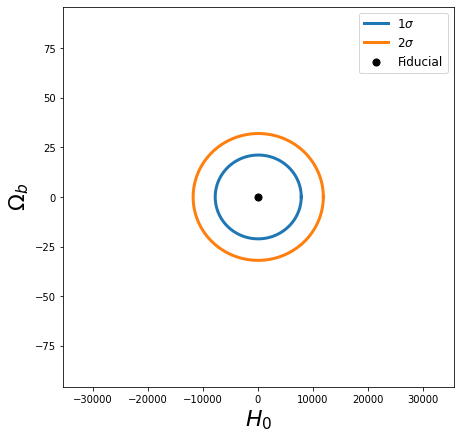

In [11]:
fisherPlotter(0,1)

In [ ]:
fisherPlotter(0,2)

In [ ]:
fisherPlotter(0,3)